In [1]:
"""
Pre-processing PlanetScope SuperDove imagery

    1. Calculate Spectral Indices:
        a. Normalized Difference Red-edge Index (NDRE)
        b. Visible Green-Based Built-Up Index (VgNIRBI)
        c. Visible Red-Based Built-Up Index (VrNIRBI)
        d. Blue-Green Normalized Built-Up Index (NDBIbg)
        e. Red-Green Normalized Built-up Index (NDBIrg)
        f. Normalized Impervious Surface Index (NISI)
    2. Check Band Correlations
    3. Minimum Noise Fraction (MNF) Transformation
    4. Remove Highly Correlated Bands
    5. Texture Calculations
    5. Export to GeoTIFF

"""
import os, sys, time
from glob import glob
import rioxarray as rxr
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import earthpy.plot as ep
import rasterio as rio
import pysptools.util as sp_utils
import geopandas as gpd
import warnings
import gc

from rioxarray.merge import merge_arrays
from rasterio.crs import CRS
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import generic_filter

warnings.filterwarnings('ignore')

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

# Load the environment variables

# maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'
maindir = '/home/jovyan/'
datadir = os.path.join(maindir,'data-store/data/iplant/home/maco4303/data/OPP')

# Coordinate Ref. System
proj = 32618  # UTM Zone 18N (Washington, D.C.)

print("Ready !")

Ready !


In [2]:
os.listdir(datadir)

['code', 'combust', 'planet', 'training']

In [3]:
# PSScene list of GeoTIFFs
# psscenes = glob(os.path.join(maindir,'data/spatial/raw/dc_data/planet-data/PSScene8Band_23/*_composite.tif'))
psscenes = glob(os.path.join(datadir,'planet/dc/*_composite.tif')) # cyverse
print([os.path.basename(f) for f in psscenes])

['2023-06-02_strip_6551575_composite.tif', '2023-06-02_strip_6551610_composite.tif']


In [4]:
# Open the files and store in a list
strips = []
for i in range(len(psscenes)):
    print(os.path.basename(psscenes[i]))
    strip = rxr.open_rasterio(
        psscenes[i],masked=True,cache=False
    ).squeeze().astype(rio.uint16)
    strips.append(strip)  # append to the empty list
    del strip

print(strips[0].rio.crs)
print(strips[0].rio.resolution())
height, width = strips[0].rio.resolution()[0], strips[0].rio.resolution()[1]

2023-06-02_strip_6551575_composite.tif
2023-06-02_strip_6551610_composite.tif
EPSG:32618
(3.0, -3.0)


In [5]:
# Merge the strips
mosaic = merge_arrays(
    dataarrays=strips,
    res=(height, abs(width)),
    crs=CRS.from_epsg(proj),
    nodata=0,
    method='max'
)

# Define the list of long names for each band
long_names = ['coastal_blue', 'blue', 'green_i', 'green', 'yellow', 'red', 'rededge', 'nir']
# Assign long names to each band
mosaic.attrs['long_name'] = tuple(long_names)
# Print raster attributes
shp, gt, wkt, nd = mosaic.shape, mosaic.spatial_ref.GeoTransform, mosaic.rio.crs, mosaic.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Bands: {mosaic.band}; \n"
    f"Band Names: {mosaic.attrs['long_name']}; \n"
    f"Data Type: {mosaic[0].dtype}")

# Write to disk
# out_img = os.path.join(maindir,'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b.tif')
out_img = os.path.join(maindir,'data-store/data_output/dc_0623_psscene8b.tif') # cyverse
mosaic.rio.to_raster(
    out_img, compress='zstd', zstd_level=9,
    dtype='uint16', driver='GTiff')
strips = []  # clear the list

print(f"Successfully exported the 8-band composite: {out_img}")

del mosaic, strips, height, width   # clean up
gc.collect()

Shape: (8, 8223, 6714); 
GeoTransform: 315267.0 3.0 0.0 4319298.0 0.0 -3.0; 
WKT: EPSG:32618; 
NoData Value: 0; 
Bands: <xarray.DataArray 'band' (band: 8)>
array([1, 2, 3, 4, 5, 6, 7, 8])
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8
    spatial_ref  int64 0; 
Band Names: ('coastal_blue', 'blue', 'green_i', 'green', 'yellow', 'red', 'rededge', 'nir'); 
Data Type: uint16
Successfully exported the 8-band composite: /home/jovyan/data-store/data_output/dc_0623_psscene8b.tif


311

### Examine Band Correlations


In [6]:
# Reload the mosaic
da = rxr.open_rasterio(out_img, masked=True, cache=False)
print(da)

<xarray.DataArray (band: 8, y: 8223, x: 6714)>
[441673776 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8
  * x            (x) float64 3.153e+05 3.153e+05 ... 3.354e+05 3.354e+05
  * y            (y) float64 4.319e+06 4.319e+06 ... 4.295e+06 4.295e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('coastal_blue', 'blue', 'green_i', 'green', 'yellow', 'r...


In [7]:
# Convert to a numpy array and test band correlations
image_np = da.values
# img_data is now a numpy array of shape (bands, height, width)
print(f"Image data shape: {image_np.shape}")
print(f"Data type: {image_np.dtype}")
# Check if the data contains only zeros or NaNs
print(f"Data contains NaNs: {np.isnan(image_np).any()}")
print(f"Data contains only zeros: {np.all(image_np == 0)}")

Image data shape: (8, 8223, 6714)
Data type: float32
Data contains NaNs: True
Data contains only zeros: False


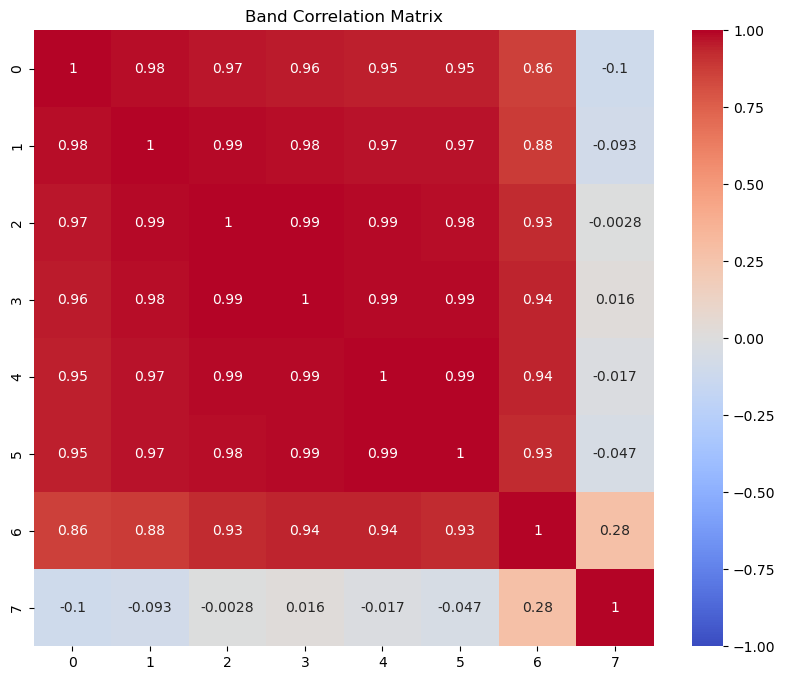

10135

In [8]:
out_png = os.path.join(maindir,'data-store/figures_output/FigX_band_correlationsV1.png')
band_correlations(da, out_png) # see __functions.py
gc.collect()

### Handle Band Correlations in Planet SuperDove Visible Bands

The Planet SuperDove visible bands (1-7) are highly correlated. 

To handle this issue, we can do some further feature extraction to generate meaningful layers before removing the correlated bands. 

First, we can calculate spectral indices to derive uncorrelated spectral features from the original bands. 

Second, we can try to distill the spectral information down using a decomposition method. Minimum Noise Fraction (MNF) minimizes noise in an image, producing sequential images of decreasing quality. Here we apply MNF to the SuperDove visible bands.

In [ ]:
##### Calculate spectral indices

In [9]:
# Copy attributes from the Green band (arbitrary, could be any band)
NDRE = da[3].copy(data=(da[7] - da[6]) / (da[7] + da[6])) # red, nir
VgNIRBI = da[3].copy(data=(da[3] - da[7]) / (da[3] + da[7]))  # 'green','nir'
VrNIRBI = da[3].copy(data=(da[5] - da[7]) / (da[5] + da[7]))  # 'red','nir'
NDBIbg = da[3].copy(data=(da[1] - da[3]) / (da[1] + da[3]))  # 'blue','green'
NDBIrg = da[3].copy(data=(da[5] - da[3]) / (da[5] + da[3]))  # 'red','green'
NISI = da[3].copy(data=(((da[1] + da[3] + da[5]) - da[7]) / ((da[1] + da[3] + da[5]) + da[7])))

# Put the indices into a list
si_stack = xr.concat([NDRE, VgNIRBI, VrNIRBI, NDBIbg, NDBIrg, NISI], dim='band')  # create and image stack

# Reorder the band numbers in prep to merge
si_stack = si_stack.assign_coords(band=np.arange(9, 9 + si_stack.shape[0]))

# Define the list of long names for each band
si_long_names = ['NDRE', 'VgNIRBI', 'VrNIRBI', 'NDBIbg', 'NDBIrg', 'NISI']
# Assign long names to each band
si_stack.attrs['long_name'] = tuple(si_long_names)

# Print raster attributes
shp, gt, wkt, nd = si_stack.shape, si_stack.spatial_ref.GeoTransform, si_stack.rio.crs, si_stack.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Bands: {si_stack.band}; \n"
    f"Band Names: {si_stack.attrs['long_name']}; \n"
    f"Data Type: {si_stack[0].dtype}")

del NDRE, VgNIRBI, VrNIRBI, NDBIbg, NDBIrg, NISI
gc.collect()

Shape: (6, 8223, 6714); 
GeoTransform: 315267.0 3.0 0.0 4319298.0 0.0 -3.0; 
WKT: EPSG:32618; 
NoData Value: nan; 
Bands: <xarray.DataArray 'band' (band: 6)>
array([ 9, 10, 11, 12, 13, 14])
Coordinates:
    spatial_ref  int64 0
  * band         (band) int64 9 10 11 12 13 14; 
Band Names: ('NDRE', 'VgNIRBI', 'VrNIRBI', 'NDBIbg', 'NDBIrg', 'NISI'); 
Data Type: float32


0

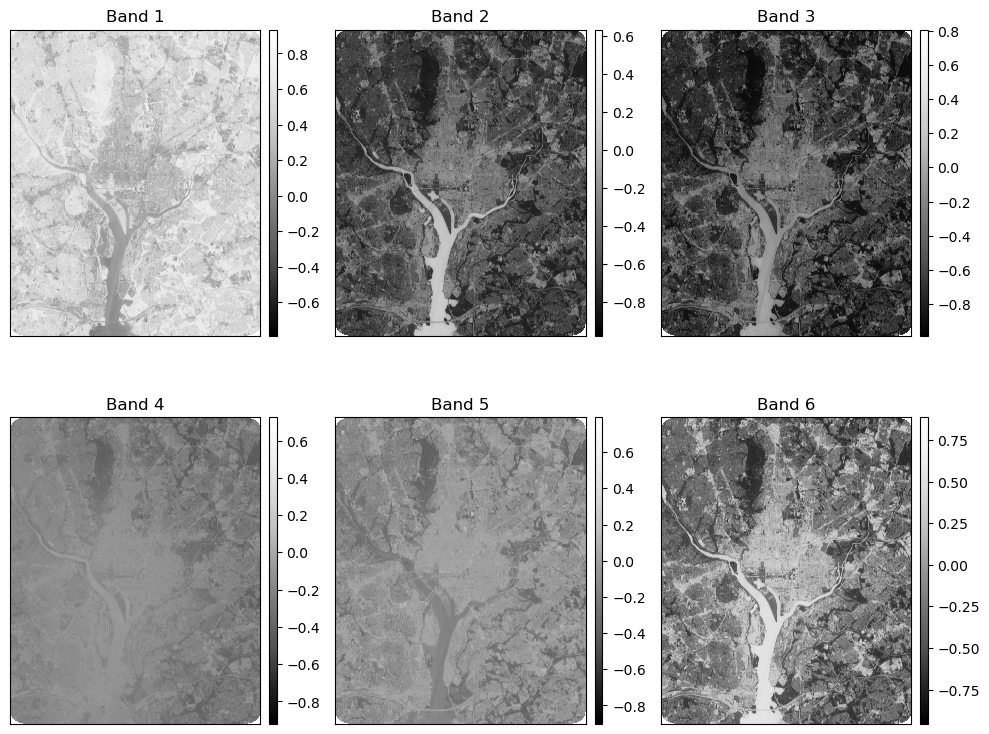

array([[<Axes: title={'center': 'Band 1'}>,
        <Axes: title={'center': 'Band 2'}>,
        <Axes: title={'center': 'Band 3'}>],
       [<Axes: title={'center': 'Band 4'}>,
        <Axes: title={'center': 'Band 5'}>,
        <Axes: title={'center': 'Band 6'}>]], dtype=object)

In [10]:
ep.plot_bands(si_stack, scale=False, figsize=(10,8))

In [ ]:
##### Calculate the MNF transformation on visible bands

In [11]:
planet_bands_vis = image_np[:7, ...]
planet_bands_vis = np.nan_to_num(planet_bands_vis, nan=-9999)
print(planet_bands_vis.shape)

(7, 8223, 6714)


In [12]:
print(f"Image array shape: {image_np.shape}; and type: {type(image_np)}")

Image array shape: (8, 8223, 6714); and type: <class 'numpy.ndarray'>


In [13]:
# MNF transform implmentation
da_mnf = mnf_transform(planet_bands_vis)  # see functions.py
print(
    f"MNF image shape: {da_mnf.shape}; \n"
    f"transposed shape: {da_mnf.T.shape}; \n"
    f"and type: {type(da_mnf)};")

MNF image shape: (6714, 8223, 7); 
transposed shape: (7, 8223, 6714); 
and type: <class 'numpy.ndarray'>;


In [14]:
# Explore the dimensionality of the data

# Filter out NoData values from the MNF-transformed image
filtered = ravel_and_filter(np.where(planet_bands_vis == -9999, -9999, da_mnf.T))
# Obtain the covariance matrix
cov_m = sp_utils.cov(filtered)
# Compute the eigenvalues, sort them, reverse the sorting
eigenvals = np.sort(np.linalg.eig(cov_m)[0])[::-1]
eigenvals_p = np.power(eigenvals, 2) / sum(np.power(eigenvals, 2))
print(f"Variance explained by MNF rotations: \n {list(map(lambda x: round(x, 3), eigenvals_p.tolist()))}")

del filtered, cov_m, eigenvals, eigenvals_p
gc.collect()

Variance explained by MNF rotations: 
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


55

In [15]:
# retain the first rotation which explains 100% (??) of the variation
da_mnf_ = da_mnf[:,:,:1].T # transpose to match the da stack
print(da_mnf_.shape)

(1, 8223, 6714)


In [18]:
# Export to GeoTIFF
# out_path = os.path.join(maindir,'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_mnf.tif')
out_path = os.path.join(maindir,'data-store/data_output/dc_0623_psscene8b_mnf.tif') # cyverse
mnf_img = array_to_tif(da_mnf_.T, da, out_path, 'float32', clip=False)  

# Convert to DataArray
mnf_array = xr.DataArray(data=da_mnf_, # transposed mnf array
                         dims=['band','y', 'x'],
                         coords={'y': da.coords['y'], 'x': da.coords['x'], 'band': [15]},
                         attrs=da.attrs)

# Set the long name for the MNF band
mnf_array.attrs['long_name'] = 'mnf1'
mnf_array.rio.write_crs(proj, inplace=True) # write the CRS
print(mnf_array)

(1, 8223, 6714)
Successfully exported array to '/home/jovyan/data-store/data_output/dc_0623_psscene8b_mnf.tif'
<xarray.DataArray (band: 1, y: 8223, x: 6714)>
array([[[-36.79403403, -36.79403403, -36.79403403, ..., -36.79403403,
         -36.79403403, -36.79403403],
        [-36.79403403, -36.79403403, -36.79403403, ..., -36.79403403,
         -36.79403403, -36.79403403],
        [-36.79403403, -36.79403403, -36.79403403, ..., -36.79403403,
         -36.79403403, -36.79403403],
        ...,
        [-36.79403403, -36.79403403, -36.79403403, ..., -36.79403403,
         -36.79403403, -36.79403403],
        [-36.79403403, -36.79403403, -36.79403403, ..., -36.79403403,
         -36.79403403, -36.79403403],
        [-36.79403403, -36.79403403, -36.79403403, ..., -36.79403403,
         -36.79403403, -36.79403403]]])
Coordinates:
  * y            (y) float64 4.319e+06 4.319e+06 ... 4.295e+06 4.295e+06
  * x            (x) float64 3.153e+05 3.153e+05 ... 3.354e+05 3.354e+05
  * band         (ba

In [ ]:
##### Stack the bands together and test for correlations again

shape: (15, 8223, 6714);
long_name: ('coastal_blue', 'blue', 'green_i', 'green', 'yellow', 'red', 'rededge', 'nir', 'NDRE', 'VgNIRBI', 'VrNIRBI', 'NDBIbg', 'NDBIrg', 'NISI', 'mnf1')


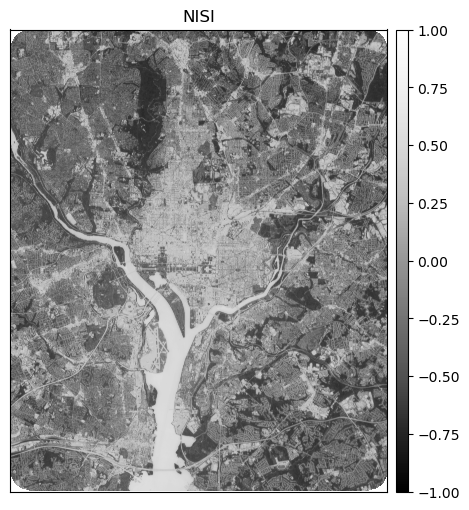

<Axes: title={'center': 'NISI'}>

In [20]:
# Create the final multi-band image stack
da_stack = xr.concat([da, si_stack, mnf_array], dim='band').astype(np.float32)

# Update the long_name attribute to include the other names
long_names = list(da_stack.attrs['long_name']) + si_long_names + ['mnf1']
da_stack.attrs['long_name'] = tuple(long_names)
print(f"shape: {da_stack.shape};\nlong_name: {da_stack.attrs['long_name']}")

# Plot the NISI index
ep.plot_bands(
    da_stack[13].squeeze(),
    scale=False,
    vmin=-1,vmax=1,
    title="NISI",
    figsize=(6,6))

In [21]:
del da, si_stack, da_mnf, da_mnf_
gc.collect()

884

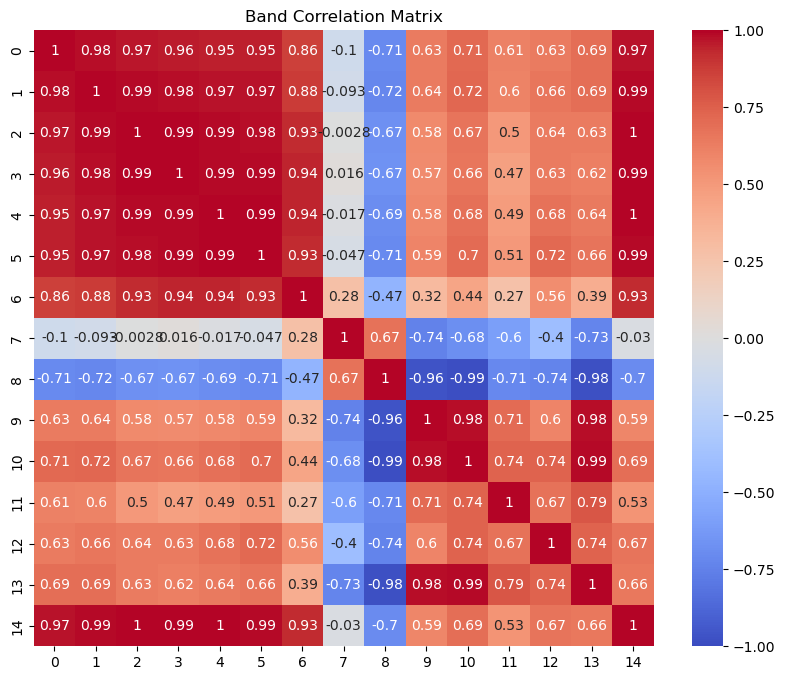

21282

In [22]:
out_png = os.path.join(maindir,'data-store/figures_output/FigX_band_correlationsV2.png')
band_correlations(da_stack, out_png) # see __functions.py
gc.collect()

#### Remove highly correlated bands

Now that we have successfully created additional, uncorrelated features. We should remove the correlated bands to minimize redundancy and save on computation time for model development. 

The visible bands of the SuperDove instrument are all highly correlated and now accounted for by the first MNF rotation. Additionally, NDRE, VrNIRBI, and VgNIRBI are all highly correlated with each other and to the NISI index so these can be removed as well.

Finally, we will create one additional correlation matrix to ensure that the remaining bands are not correlated.

In [23]:
band_idx_to_keep = [7,11,12,13,14] # uncorrelated bands
da_stack_ = da_stack.isel(band=band_idx_to_keep)

# Update the long_name attribute to reflect only the selected bands
new_band_names = [long_names[i] for i in band_idx_to_keep]
print(f'Uncorrelated bands: {new_band_names}')
da_stack_.attrs['long_name'] = tuple(new_band_names)
print(da_stack_.shape)

Uncorrelated bands: ['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'mnf1']
(5, 8223, 6714)


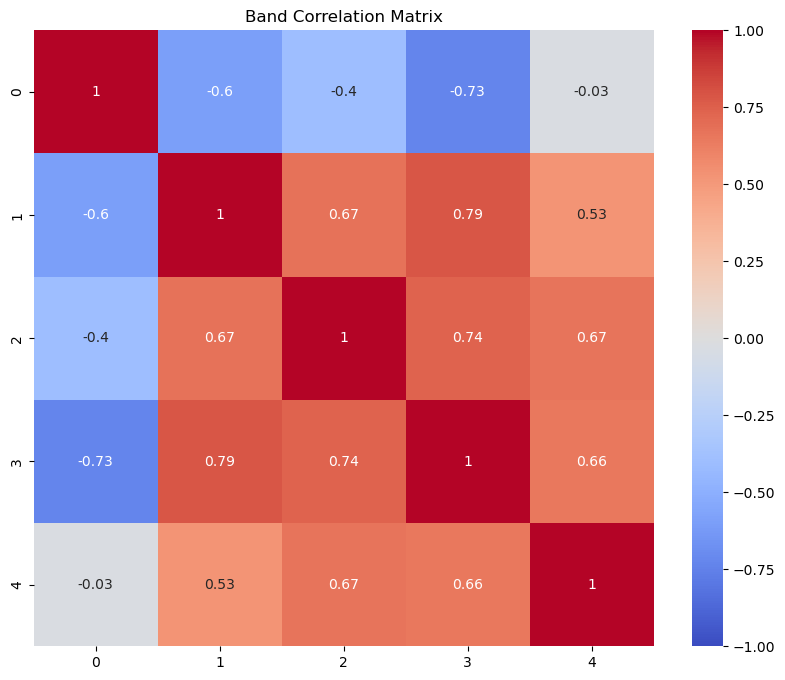

7155

In [24]:
out_png = os.path.join(maindir,'data-store/figures_output/FigX_band_correlationsV3.png')
band_correlations(da_stack_, out_png) # see __functions.py
gc.collect()

In [25]:
del da_stack
gc.collect()

0

In [30]:
print(
    f"Shape: {da_stack_.shape}; \n"
    f"CRS:  {da_stack_.rio.crs}; \n"
    f"NoData Value: {da_stack_.rio.nodata}; \n"
    f"Bands: {da_stack_.band}; \n"
    f"Band Names: {da_stack_.long_name}; \n"
    f"Data Type: {da_stack_[0].dtype}")

Shape: (5, 8223, 6714); 
CRS:  EPSG:32618; 
NoData Value: None; 
Bands: <xarray.DataArray 'band' (band: 5)>
array([ 8, 12, 13, 14, 15])
Coordinates:
  * band         (band) int64 8 12 13 14 15
    spatial_ref  int64 0; 
Band Names: ('nir', 'NDBIbg', 'NDBIrg', 'NISI', 'mnf1'); 
Data Type: float32


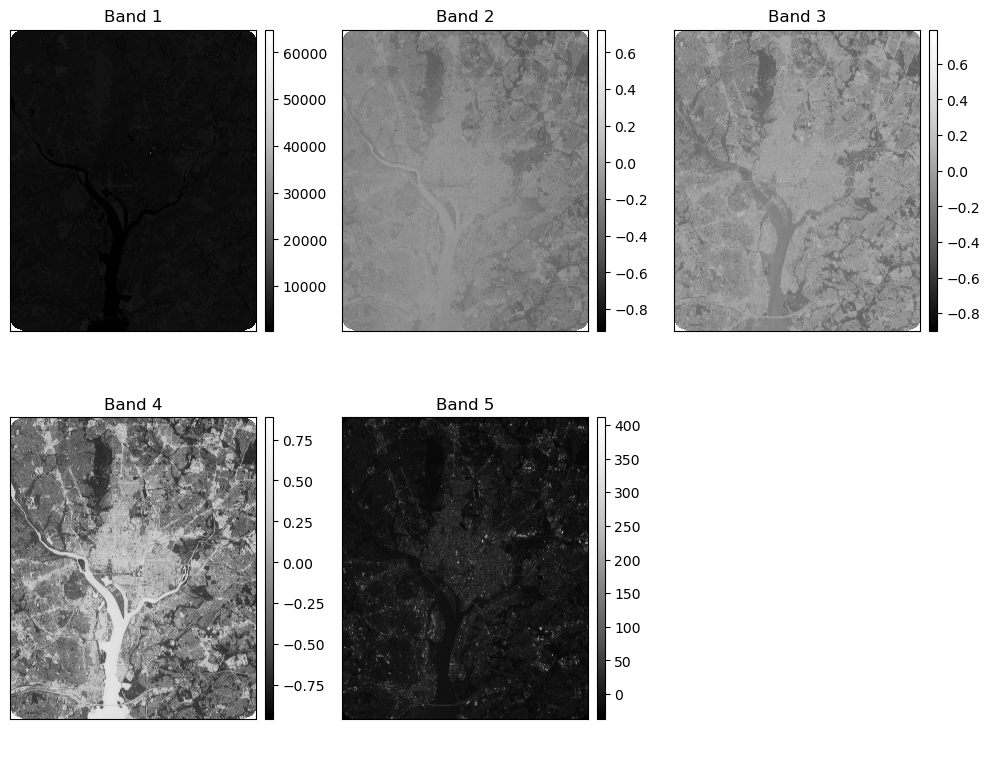

array([[<Axes: title={'center': 'Band 1'}>,
        <Axes: title={'center': 'Band 2'}>,
        <Axes: title={'center': 'Band 3'}>],
       [<Axes: title={'center': 'Band 4'}>,
        <Axes: title={'center': 'Band 5'}>, <Axes: >]], dtype=object)

In [29]:
# Plot the final uncorrelated bands
ep.plot_bands(da_stack_, figsize=(10,8))

#### Calculate Simple Texture Features

Now that we have an image stack of uncorrelated bands, we can use some feature extraction to create additional data. In particular, creating textural metrics from the spectral data may improve image classification. In the section below, we calculate image texture using a simple moving window analysis on the Normalised Impervious Surface Index (NISI). We use the NISI because of its sensitivity to impervious surfaces, characterizing texture patterns of the built environment.

In [ ]:
# TEXTURE ANALYSIS

In [37]:
print(f"Band Names: {da_stack_.long_name}\nBand Inices: {da_stack_.band.values}")
band_mapping = dict(zip(da_stack_.long_name, da_stack_.band.values))
print(band_mapping)

Band Names: ('nir', 'NDBIbg', 'NDBIrg', 'NISI', 'mnf1')
Band Inices: [ 8 12 13 14 15]
{'nir': 8, 'NDBIbg': 12, 'NDBIrg': 13, 'NISI': 14, 'mnf1': 15}


In [38]:
# Select the NISI band for analysis
nisi = da_stack_[3]
print(nisi)

<xarray.DataArray (y: 8223, x: 6714)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    band         int64 14
  * x            (x) float64 3.153e+05 3.153e+05 ... 3.354e+05 3.354e+05
  * y            (y) float64 4.319e+06 4.319e+06 ... 4.295e+06 4.295e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('nir', 'NDBIbg', 'NDBIrg', 'NISI', 'mnf1')


Processing a 5x5 window size ...


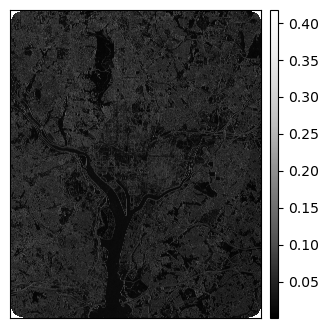

Elapsed time for 5x5: 12.03 minutes.
Processing a 9x9 window size ...


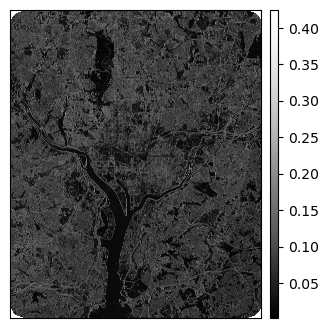

Elapsed time for 9x9: 12.31 minutes.
Processing a 27x27 window size ...


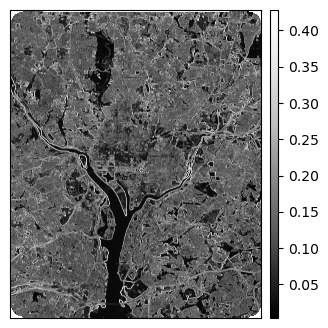

Elapsed time for 27x27: 13.95 minutes.
Total elapsed time: 38.29 minutes.


In [40]:
t0 = time.time()

# Define the window size (N x N)
window_sizes = [5,9,27]  # 5x5, 9x9, 27x27

da_out = {} # to store the data arrays
for window_size in window_sizes:
    t00 = time.time()
    name = str(window_size)+'x'+str(window_size)
    print(f"Processing a {name} window size ...")
    
    # Calculate the standard deviation using a moving window
    nisi_std = generic_filter(nisi, np.std, size=window_size)
    
    # Convert the result to a DataArray with the same coordinates and dimensions as the original band
    nisi_std_da = xr.DataArray(
        nisi_std,
        dims=nisi.dims,
        coords=nisi.coords,
        attrs=nisi.attrs
    )

    # Prep the array for export as a GeoTIFF
    # Assign the long name attribute
    nisi_std_da.attrs['long_name'] = 'NISI' + str(name)
    nisi_std_da.rio.write_crs(proj, inplace=True) # write the CRS

    # Plot the result to visualize the texture
    ep.plot_bands(nisi_std_da, figsize=(4,4))

    da_out[name] = nisi_std_da

    t1 = (time.time() - t00) / 60
    print(f"Elapsed time for {name}: {t1:.2f} minutes.")

t2 = (time.time() - t0) / 60
print(f"Total elapsed time: {t2:.2f} minutes.")

In [41]:
# Create a multiband image stack from the results
da_texture = xr.concat(list(da_out.values()), dim='band')

# Assign band labels (window sizes) as a coordinate for the 'band' dimension
da_texture = da_texture.assign_coords(band=np.arange(6, 6 + len(da_out)))

# Set the long_name attribute for each band
new_names = ['NISI5x5','NISI9x9','NISI27x27']
da_texture.attrs['long_name'] = tuple(new_names)

# View the shape of the multiband texture stack
print(
    f"Shape: {da_texture.shape}; \n"
    f"CRS:  {da_texture.rio.crs}; \n"
    f"NoData Value: {da_texture.rio.nodata}; \n"
    f"Bands: {da_texture.band}; \n"
    f"Band Names: {da_texture.long_name}; \n"
    f"Data Type: {da_texture[0].dtype}")

Shape: (3, 8223, 6714); 
CRS:  EPSG:32618; 
NoData Value: None; 
Bands: <xarray.DataArray 'band' (band: 3)>
array([6, 7, 8])
Coordinates:
    spatial_ref  int64 0
  * band         (band) int64 6 7 8; 
Band Names: ('NISI5x5', 'NISI9x9', 'NISI27x27'); 
Data Type: float32


['NISI5x5', 'NISI9x9', 'NISI27x27']


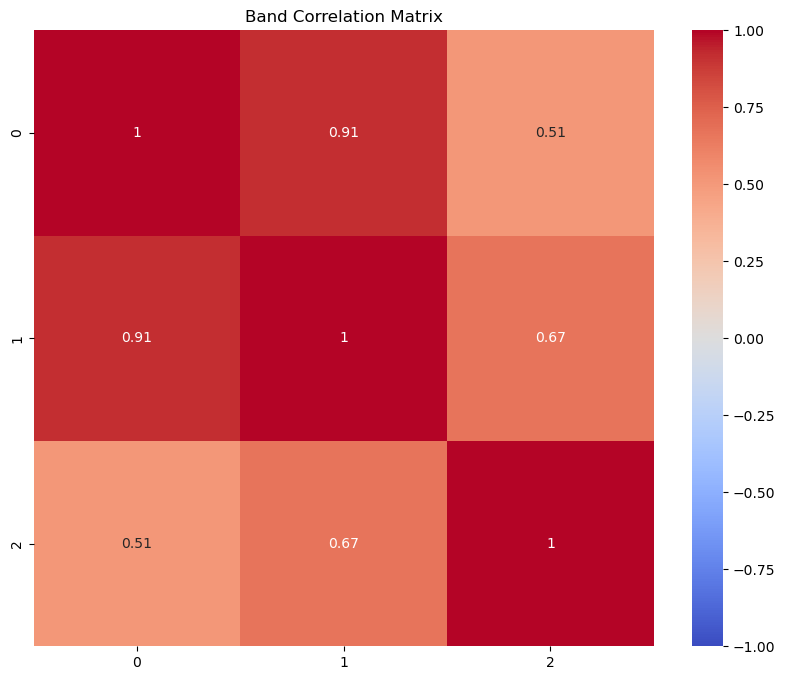

6139

In [43]:
# Test the band correlations to make sure we can keep them all ...
print(new_names)
# Plot the correlation matrix
out_png = os.path.join(maindir,'data-store/figures_output/FigX_band_correlationsV4_texture.png')
band_correlations(da_texture, out_png)
gc.collect()

In [47]:
# out_img = os.path.join(maindir,'data-store/data_output/dc_0623_psscene8b_nisi_texture.tif') # cyverse
# da_texture.rio.to_raster(out_img, compress='zstd', zstd_level=9, driver='GTiff')

In [ ]:
# print_raster(out_img, open_file=True)

In [ ]:
# Test class seperability to identify which texture metric(s) should be kept

In [58]:
ref_fp = os.path.join(datadir,'training/dc_data_reference_footprints.gpkg')
ref = gpd.read_file(ref_fp)
ref.head()

,class_code,areaUTMsqft,uid,description,code,geometry
0,CS,357.783709,1CS,Composition Shingle,0,"POLYGON ((324215.868 4313568.665, 324215.792 4..."
1,CS,918.640862,2CS,Composition Shingle,0,"POLYGON ((324602.816 4311717.247, 324604.322 4..."
2,CS,1383.414170,3CS,Composition Shingle,0,"POLYGON ((327253.581 4300371.859, 327258.154 4..."
3,CS,836.410297,4CS,Composition Shingle,0,"POLYGON ((333608.130 4306267.691, 333607.957 4..."
4,CS,330.514264,5CS,Composition Shingle,0,"POLYGON ((326482.699 4300939.466, 326487.386 4..."


In [81]:
# First, calculate the zonal mean for building footprints.
t0 = time.time()

affine = da_texture.rio.transform()
bands = da_texture.shape[0]
band_desc = list(da_texture.long_name)

results = []  # Initialize results list

for band in range(0, bands):
    print(f'Processing band {band}')
    band_data = da_texture[band].values  # Convert to numpy array
    
    stats = zonal_stats(
        ref[['uid', 'class_code', 'geometry']],
        band_data,
        affine=affine,
        stats=['mean'],
        all_touched=True,
        nodata=da_texture.rio.nodata,
        geojson_out=True  # Retain original attributes in the output
    )
    
    # Convert the list of dicts to a DataFrame, extract properties
    stats_df = pd.DataFrame(stats)
    
    # Tidy the columns
    stats_df['uid'] = stats_df['properties'].apply(lambda x: x.get('uid'))
    stats_df['class_code'] = stats_df['properties'].apply(lambda x: x.get('class_code'))
    stats_df['mean'] = stats_df['properties'].apply(lambda x: x.get('mean'))
    stats_df = stats_df[['uid', 'class_code', 'mean']]
    # Rename the band statistic column
    stats_df.rename(columns={'mean': f'{band_desc[band - 1]}'}, inplace=True)

    results.append(stats_df)
    
t1 = (time.time() - t0) / 60
print(f"Total elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

In [73]:
results_df = results[1].merge(results[2], on='uid', how='left')  # Merge on uid
results_df = results_df.merge(results[0], on='uid', how='left')  # Merge on uid
results_df = results_df.drop(['class_code_x', 'class_code_y'], axis='columns')
results_df.head()

,uid,NISI5x5,NISI9x9,class_code,NISI27x27
0,1CS,0.170517,0.144136,CS,0.129775
1,2CS,0.088528,0.126217,CS,0.059827
2,3CS,0.039213,0.062482,CS,0.026881
3,4CS,0.090863,0.152744,CS,0.069648
4,5CS,0.061555,0.091352,CS,0.035924


In [80]:
import scipy.stats as stats

# Assuming df is your DataFrame with columns 'class' and 'reflectance_band1'
classes = results_df['class_code'].unique()
# Perform one-way ANOVA
f_value5, p_value5 = stats.f_oneway(*(results_df[results_df['class_code'] == cls]['NISI5x5'] for cls in classes))
f_value9, p_value9 = stats.f_oneway(*(results_df[results_df['class_code'] == cls]['NISI9x9'] for cls in classes))
f_value27, p_value27 = stats.f_oneway(*(results_df[results_df['class_code'] == cls]['NISI27x27'] for cls in classes))

print(f'ANOVA F-value (NISI5x5): {f_value5}, p-value: {p_value5}\n')
print(f'ANOVA F-value (NISI9x9): {f_value9}, p-value: {p_value9}\n')
print(f'ANOVA F-value (NISI27x27): {f_value27}, p-value: {p_value27}')

ANOVA F-value (NISI5x5): 636.1603889522405, p-value: 0.0

ANOVA F-value (NISI9x9): 162.3503716127816, p-value: 9.299892841956134e-206

ANOVA F-value (NISI27x27): 300.5427478929939, p-value: 0.0


In [84]:
print(da_texture.band.values)
print(da_texture.long_name)

[6 7 8]
('NISI5x5', 'NISI9x9', 'NISI27x27')


In [88]:
# Retain the 5x5 texture
da_texture_ = da_texture.isel(band=0)
da_texture_.attrs['long_name'] = ['NISI5x5']
print(da_texture_)

<xarray.DataArray (y: 8223, x: 6714)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x            (x) float64 3.153e+05 3.153e+05 ... 3.354e+05 3.354e+05
  * y            (y) float64 4.319e+06 4.319e+06 ... 4.295e+06 4.295e+06
    spatial_ref  int64 0
    band         int64 6
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ['NISI5x5']


In [89]:
# Merge with the original data
stack_out = xr.concat([da_stack_, da_texture_], dim='band') # Concatenate all bands

new_names = ['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5']
stack_out.attrs['long_name'] = tuple(new_names)

print(stack_out.shape)

(6, 8223, 6714)


In [90]:
del da_texture, da_texture_, results_df, band_data, ref, stats, stats_df
gc.collect()

2913

In [ ]:
# PERFORM BAND NORMALIZATION

In [91]:
scaler = StandardScaler() # from sklearn

image_np = stack_out.values # convert to numpy array

# Reshape the data to (bands, pixels)
bands, height, width = image_np.shape
image_np_t = image_np.reshape(bands, -1).T  # Transpose to get shape (pixels, bands)
# Create a mask for non-NaN values
valid_mask = ~np.isnan(image_np_t).any(axis=1)
# Handle NaN for the correlation matrix
image_np_tm = image_np_t[valid_mask]

# Fit the scalar transform to the data
image_np_tmn = scaler.fit_transform(image_np_tm)

# Reshape normalized data back to (bands, height, width)

# Create an empty array and place the normalized values back into the original shape
image_np_tmn_r = np.full(image_np_t.shape, np.nan)
image_np_tmn_r[valid_mask] = image_np_tmn
image_np_tmn_r = image_np_tmn_r.T.reshape(bands, height, width)

# Convert the normalized array back to a DataArray
stack_out_norm = xr.DataArray(
    image_np_tmn_r,
    dims=stack_out.dims,
    coords=stack_out.coords,
    attrs=stack_out.attrs
)

print(stack_out_norm.shape)

(6, 8223, 6714)


In [92]:
del image_np, image_np_t, valid_mask, image_np_tm, image_np_tmn, image_np_tmn_r
gc.collect()

0

In [93]:
# Save the normalized image array out with the correct CRS and compression
# stack_out_norm_fp = os.path.join(maindir,'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_final_norm.tif')
stack_out_norm_fp = os.path.join(maindir,'data-store/data_output/dc_0623_psscene8b_final_norm.tif')

stack_out_norm.rio.write_crs(proj, inplace=True) # write the CRS
stack_out_norm.rio.to_raster(stack_out_norm_fp, compress='zstd', zstd_level=9, driver='GTiff', dtype='float32')

print(f"Saved raster stack to: {stack_out_norm_fp}")

Saved raster stack to: /home/jovyan/data-store/data_output/dc_0623_psscene8b_final_norm.tif


In [94]:
gc.collect()

6